# **Exploring documental databases with topic models and graph analysis**
# National Science Foundation data



---




Date: Apr 11, 2021

Author: Jerónimo Arenas-García (jeronimo.arenas@uc3m.es)

Version 1.0



In [1]:
# Common imports 

import numpy as np
import pandas as pd
import zipfile as zp
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

#For fancy table Display
%load_ext google.colab.data_table

In [2]:
#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
from google.colab import drive
drive.mount("/content/drive")
local_folder = '/content/drive/My Drive/DATOS/TEACHING/Aplicaciones de ML/Material/2. NLP/'

KeyboardInterrupt: ignored

## **1. Project Objectives**


---

In this notebook we are going to develop a project that will incorporate the most relevant elements of natural language processing that we will study in the subject.

The objective is to analyze the main themes of a corpus of documents, as well as the structure of the data corpus itself using different visualizations to facilitate the design and adjustment of the tools used in the process.

The following figure summarizes the steps and  libraries that we will follow during this project.

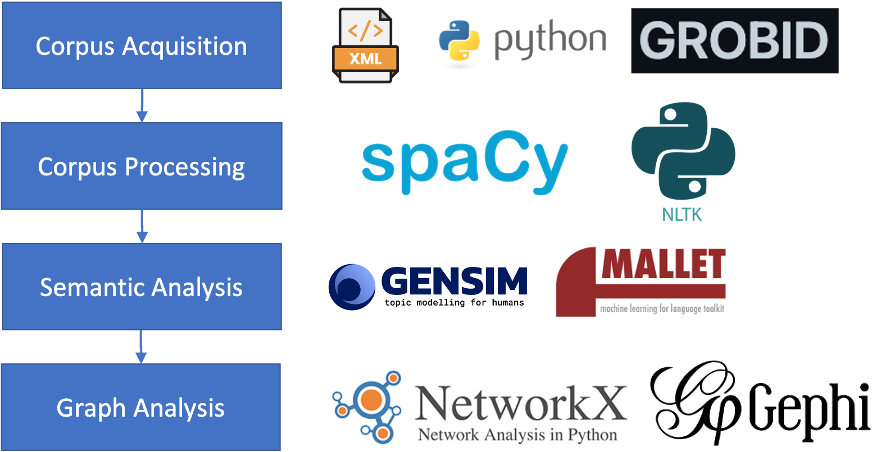

   - ***Corpus Acquisition***: We will ingest a collection of documents for further processing in python. Import techniques will differ based on the kind of documents we need to work with, and their original format (i.e., PDF, XML, etc). It some cases, we will need to use crawling techniques.

   - ***Corpus Processing***: Here, we will work with unstructured text, i.e., the original text as it was written by a person. In its original format, the data cannot be efficiently used by most machine learning algorithms, so it is necessary to apply a series of transformation to make data usable and fit the characteristics of machine learning algorithms. 

   - ***Semantic Analysis***: We will rely on Topic Modeling and, in particular, Latent Dirichlet Allocation, to find out the leading topics in the dataset as well as the main topics of each document.

   - ***Graph Analysis***: Finally, a graph will be calculated based on the semantic characterization of all documents. Some relevant statistics of the graph will be calculated, and relevant documents will be identified from this perspective. For graph visualization we will rely on a external application (gephi) that offers interactivity and better scalability properties.

After completing the project, students will have acquired the following skills:

   - Ability to work with different sources of textual data

   - Knowledge of the most used text preprocessing steps for learning topics

   - Ability to handle different topic modeling tools, knowing which are the hyperparameters that must be adjusted, and the statistics that can facilitate their adjustment

   - Greater skill in analyzing the results of machine learning algorithms

   - Knowledge of visualization techniques commonly used in topic and graph modeling

   - Knowledge of some of the *state of the art* libraries for natural language processing in python

### *1.1. Installing and Updating Python Libraries*

#### 1.1.1. Spacy

In [ ]:
!pip install --upgrade spacy
import spacy
!python -m spacy download en_core_web_md

#### 1.1.2. Gensim and pyLDAvis

We upgrade to version 3.8.3. that provides the Mallet wrapper. We install also the Java environment to run the Mallet libraries.

In [4]:
!pip install --upgrade gensim==3.8.3
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 24.2MB 46.0MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.6MB 4.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=267d556b9a1c515057040e928aa6f17683d515e9a393289b4d326eebadca9bd6
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [5]:
import os       #importing os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [6]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-05-08 23:44:55--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.8MB/s    in 0.9s    

2021-05-08 23:44:56 (17.8 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [7]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this 

### *1.2. Gephi: Graph visualization and Analysis*

In this Notebook we will semantic graphs, and visualize them using an external application: [Gephi](https://gephi.org/). For that, you will need to install Gephi in your computer.

#### 1.2.1. Installation and configuration of Gephi

   - Gephi is a standalone application. You can download the latest release from the [Gephi website](https://gephi.org/). 
   - The latest release (0.9.2) is available for Windows, MacOS and Linux platforms.
   - There exists a catalogue of [Gephi tutorials](https://gephi.org/users/) for novice users. The [Quick Start Tutorial](https://gephi.org/tutorials/gephi-tutorial-quick_start.pdf?utm_source=dlvr.it&utm_medium=twitter) contains some practical hints to get beatiful graphs and configure them according to your needs.

---
**Configuration hint**

To allow Gephi to work with larger graphs (i.e., more nodes and edges) you can configure the memory used by the JVM running the application. You can do that by editing the files under `Resources/gephi/bin` for Windows or `Resources/gephi/etc` for MacOS and Linux.

There, you will find the following lines
```
# options used by the launcher by default, can be overridden by explicit
# command line switches
default_options="--branding gephi -J-Xms64m -J-Xmx512m -J-Xverify:none -J-Dsun.java2d.noddraw=true -J-Dsun.awt.noerasebackground=true -J-Dnetbeans.indexing.noFileRefresh=true -J-Dplugin.manager.check.interval=EVERY_DAY"
```
The switches `-J-Xms` and `-J-Xmx` control the minimum and maximum RAM memory assigned to the JVM. You can increase their values according to the available RAM in your computer.


#### 1.2.2. Generating CSV files for Gephi Nodes and Edges Tables

Recall that in order to process semantic graphs we are going to follow the following steps:

   1. Importing the corpus, with raw text description and metadata associated to each document
   2. Preprocessing the text description of each document
   3. Generate and optimize a topic model based on text descriptions
   4. Obtain topic-based representations for each document based on the trained topic model
   5. Compute semantic distances among each pair of documents based on their topic-based representations

By doing so, we have essentially already generated the semantic graph:
   - **Graph Nodes:** are the documents in the corpus collection. Each node will have a set of attributes (e.g., Year, Title, Institution, Budget, etc).
   - **Graph Edges:** are links among nodes. Our semantic graphs will have undirected and weighted edges. The weight of each edge between any pair of nodes is precisely their semantic distance as computed in step 5. above

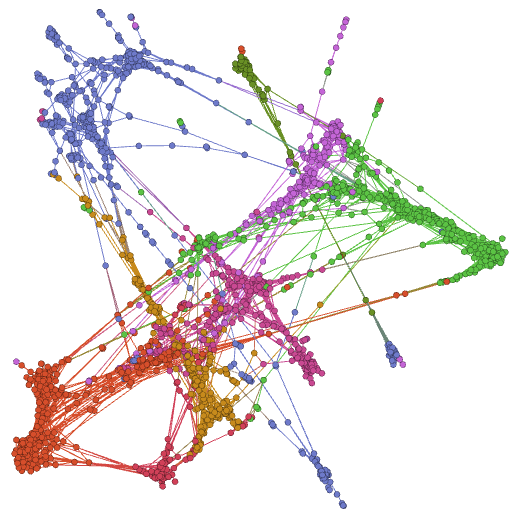




In order to import our dat to Gephi we will need to create two different tables as CSV files, for nodes and edges respectively. We can easily create them from a Pandas Dataframe exporting it using the `to_csv` function.

   - **NSF_nodes.csv**: Should contain one row per document. It is mandatory to include column `Id` that contains the id assigned to each node. Apart from that, we can include any other columns for the other available metadata.
   - **NSF_edges.csv**: Should contain one row per edge. It is mandatory to include columns `Source` and `Target`, though we will also include an additional `Weight` column for the semantic similarities that are used as link weights.

   

#### 1.2.3. Reducing the size of the nodes and edges tables

Very large graphs will take a lot of resources to render and analyse. In order to avoid Gephi recurrently crashing for this reason, it is advised to sample the graph. In order to do, we will carry out the two following procedures:

   - Random sampling of nodes
   - Edge thresholding, keeping only edges with high similarity

You could start with rather aggresive sampling and reduce the sampling factor progressively.

## **2. Corpus acquisition**
---

We will work with a collection of research projects funded by the US *National Science Foundation (NSF)*. NSF funds fundamental research projects in all disciplines. The summary and some metadata of all awarded projects can be downloaded from the [NSF Open Data website](https://www.nsf.gov/awardsearch/download.jsp).

Some of these datasets have already been downloaded for this session, spanning a three year period. Note you can work with any other years or expand the time span.

   - [Zip file with data from 2019](http://www.tsc.uc3m.es/~jarenas/NSFdata/2019.zip)
   - [Zip file with data from 2018](http://www.tsc.uc3m.es/~jarenas/NSFdata/2018.zip)
   - [Zip file with data from 2017](http://www.tsc.uc3m.es/~jarenas/NSFdata/2017.zip)
   - [Sample XML file: 1600057.xml](http://www.tsc.uc3m.es/~jarenas/NSFdata/1600057.xml)

You could download these data files now, or load them using the provided links using a python library for retrieving data from the web, e.g., in this notebook we will use the module `requests`.



### *2.1. Exploring file structure*

NSF project information is provided in XML files. Projects are yearly grouped in `.zip` files, and each project is saved in a different XML file. To explore the structure of such files, we will use the file `1600057.xml`. Parsing XML files in python is rather easy using the native `xml` module that provides class `ElementTree`. 

Other libraries that you could use are [`lxml`](https://lxml.de/) and the very powerful[`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

To introduce some of the most important features for working with XML files we will follow the <a href=http://docs.python.org/3.4/library/xml.etree.elementtree.html#module-xml.etree.ElementTree>tutorial</a> that comes with the documentation of the library.

#### 2.1.1. File format

To start with, you can have a look at the contents of the example file. We are interested in the following information of each project:

   * Project identifier
   * Project Title
   * Project Abstract
   * Budget
   * Starting Year (we will ignore project duration)
   * Institution (name, zipcode, and state)

Take a look at the printed file and locate the information enumerated in the list.**bold text**

In [ ]:
## Read files from web. You can comment this block if you are reading files
## from your local drive
import requests
from io import BytesIO #Useful for presenting data as a byte stream

url_base = 'http://www.tsc.uc3m.es/~jarenas/NSFdata/'
web_read = True

if web_read:
    project_url = url_base + '1600057.xml'
    project_xml = requests.get(project_url).text
else:
    pass #Implement here function to read XML file

print(project_xml)

<?xml version="1.0" encoding="UTF-8"?>
<rootTag>
<Award>
<AwardTitle>Novel States in Spin-Orbit-Coupled and Correlated Materials</AwardTitle>
<AwardEffectiveDate>08/01/2016</AwardEffectiveDate>
<AwardExpirationDate>12/31/2016</AwardExpirationDate>
<AwardAmount>306810</AwardAmount>
<AwardInstrument>
<Value>Continuing grant</Value>
</AwardInstrument>
<Organization>
<Code>03070000</Code>
<Directorate>
<LongName>Direct For Mathematical &amp; Physical Scien</LongName>
</Directorate>
<Division>
<LongName>Division Of Materials Research</LongName>
</Division>
</Organization>
<ProgramOfficer>
<SignBlockName>Tomasz Durakiewicz</SignBlockName>
</ProgramOfficer>
<AbstractNarration>Non-technical Abstract:&lt;br/&gt;Modern condensed matter physics research has produced novel materials with fundamental properties that underpin a remarkable number of cutting-edge technologies. It is now generally accepted that novel materials are necessary for critical advances in technologies and whoever discovers no

#### 2.1.2. Parsing the XML project files

XML is an inherently hierarchical data format, and the most natural way to represent it is with a tree. The `ElementTree` module has two classes for this purpose:

   * `ElementTree` represents the whole XML document as a tree
   * `Element` represents a single node in this tree

We can parse the XML structure directly from a string, or by reading an XML file


In [ ]:
import xml.etree.ElementTree as ET

root = ET.fromstring(project_xml)

# Use the following fragment if you want to read data from a local file
# tree = ET.parse(xmlfile)
# root = tree.getroot

`fromstring()` parses XML from a string directly into an `Element`, which is the root element of the parsed tree. Other parsing functions may create an `ElementTree`, but we will not cover them here.



**Exercise**: Implement a function that parses an XML string and provides as its output a dictionary with fields:

    project_code      (string)
    title             (string)
    abstract          (string)
    budget            (float)
    year              (string)
    institution       (tuple with elements: name, zipcode, and statecode)


In [ ]:
def parse_xmlproject(xml_string):
    """This function processess the specified XML field,
    and outputs a dictionary with the desired project information
    
    :xml_string: String with XML content
    :Returns: Dictionary with indicated files
    """
    
    #<SOL>
    root = ET.fromstring(xml_string)
    dictio = {}
    
    for child in root[0]:
        if child.tag.lower() == 'awardtitle':
            dictio['title'] = child.text
        elif child.tag.lower() == 'awardeffectivedate':
            dictio['year'] = str(child.text[-4:])
        elif child.tag.lower() == 'awardamount':
            dictio['budget'] = float(child.text)
        elif child.tag.lower() == 'abstractnarration':
            dictio['abstract'] = child.text
        elif child.tag.lower() == 'awardid':
            dictio['project_code'] = child.text
        elif child.tag.lower() == 'institution':
            #For the institution we have to access the children elements
            #and search for the name, zipcode, and statecode only
            name = ''
            zipcode = ''
            statecode = ''
            for child2 in child:
                if child2.tag.lower() == 'name':
                    name = child2.text
                elif child2.tag.lower() == 'zipcode':
                    zipcode = child2.text
                elif child2.tag.lower() == 'statecode':
                    statecode = child2.text
            dictio['institution'] = (name, zipcode, statecode)
    
    return dictio
    #</SOL>

#Test the function and print the result
parse_xmlproject(project_xml)

{'abstract': 'Non-technical Abstract:<br/>Modern condensed matter physics research has produced novel materials with fundamental properties that underpin a remarkable number of cutting-edge technologies. It is now generally accepted that novel materials are necessary for critical advances in technologies and whoever discovers novel materials generally controls the science and technology of the future. Transition metal oxides have attracted enormous interest within both the basic and applied science communities.  However, for many decades, the overwhelming balance of effort was focused on the 3d-elements (such as iron, copper, etc.) and their compounds; the heavier 4d- and 5d-elements (such as ruthenium, iridium, etc., which constitute two thirds of the d-elements listed in the Periodic Table) and their compounds have been largely ignored until recently. The principal investigator seeks to discover novel materials containing 4d- and/or 5d-elements and understand how they offer wide-rang

### *2.2. Building the dataset*

Now, we will use the function you just implemented, to create a database that we will use throughout the project.

For simplicity, in this section we will simply store the dataset as a list containing the dictionaries associated to each of the considered projects in a time interval.

In [ ]:
# Construct an iterator (or a list) for the years you want to work with
years = [2017, 2018, 2019]
NSF_data = []

for year in years:
    print('\nDownloading file for year', year, '...')
    if web_read:
        url = url_base + str(year) + '.zip'
        binary_file = BytesIO(requests.get(url).content)
        zpobj = zp.ZipFile(binary_file)
    else:
        pass #Read zpobj directly from local file

    for count, fileinzip in enumerate(zpobj.namelist()):
        if not count%1000:
            print('\rProcessing file', str(count), end='')
        if fileinzip.endswith('xml'):
            #Some files seem to be incorrectly parsed
            try:
                project_dictio = parse_xmlproject(zpobj.read(fileinzip))
                if project_dictio['abstract']: #We keep only the projects with abstract
                    NSF_data.append(project_dictio)
            except:
                pass




Processing file 12000
Processing file 12000
Processing file 12000

We will extract some characteristics of the constructed dataset:

Number of projects in dataset: 37153
Average budget of projects in dataset (USD): 478966.6126019433
Number of unique institutions in dataset: 3230


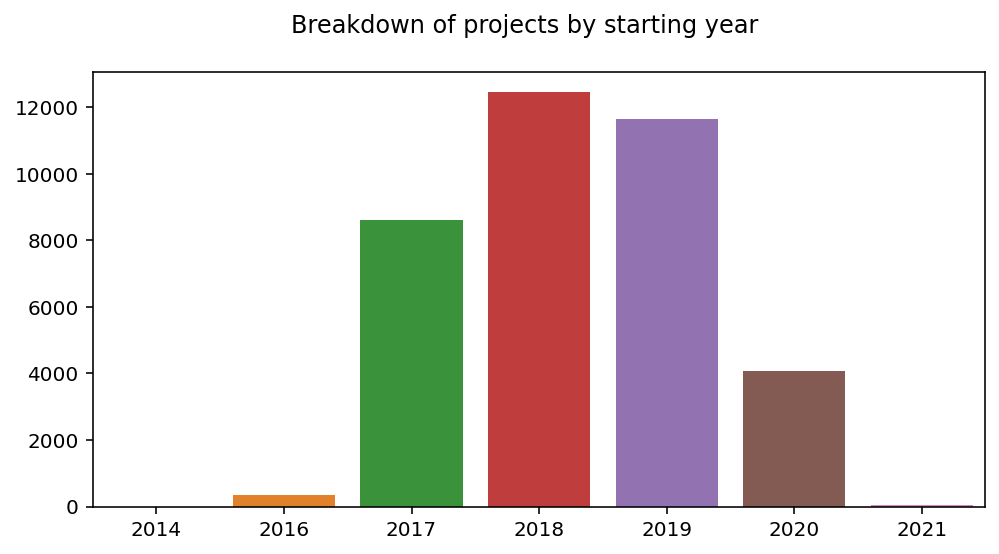

In [ ]:
print('Number of projects in dataset:', len(NSF_data))

####
budget_data = list(map(lambda x: x['budget'], NSF_data))
print('Average budget of projects in dataset (USD):', np.mean(budget_data))

####
insti_data = list(map(lambda x: x['institution'] if 'institution' in x else None, NSF_data))
print('Number of unique institutions in dataset:', len(set(insti_data)))

#### Breakdown of projects by starting year
counts = dict()
for project in NSF_data:
    counts[project['year']] = counts.get(project['year'],0) + 1

keys = list(counts.keys())
# get values in the same order as keys, and parse percentage values
vals = [counts[k] for k in keys]
keys = [int(k) for k in keys]
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
fig.suptitle('Breakdown of projects by starting year')
sns.barplot(ax = axes, x=keys, y=vals)
plt.show()

## **2. Preprocessing of the Projects Abstracts**

Topic modelling algorithms process vectorized data. In order to apply them, we need to transform the raw text input data into a vector representation. To do so, we will remove irrelevant information from the text data and preserve as much relevant information as possible to capture the semantic content in the document collection.

Thus, we will proceed with the following steps:

1. Tokenization
2. Homogeneization
3. Cleaning
4. Bag of Words Calculation

### *2.1. Text Preprocessing*

In [ ]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

def text_preprocessing(rawtext):
    doc = nlp(rawtext)
    lemmatized = ' '.join([token.lemma_ for token in doc 
                           if token.is_alpha
                           and token.pos_ in valid_POS
                           and not token.is_stop])
    return lemmatized

We will create a list that contains just the abstracts in the dataset. As the order of the elements in a list is fixed, it will be later straightforward to match the processed abstracts to metadata associated to their corresponding projects.

In [ ]:
NSF_abstracts = list(map(lambda x: x['abstract'], NSF_data))
NSF_lemmas = []
nprojects = len(NSF_abstracts)

for n, abstract in enumerate(NSF_abstracts):
    if not n%100:
        print('\rPreprocessing abstract', n, 'out of', nprojects, end='', flush=True)
    NSF_lemmas.append(text_preprocessing(abstract))

Preprocessing abstract 37100 out of 37153

In [ ]:
for el in NSF_data:
    if 'institution' not in el.keys():
        el['institution'] = ('NA', 'NA', 'NA')
        
NSF_df = pd.DataFrame([[el['project_code'], el['title'], int(el['year']), el['budget'],
                       el['institution'][0], el['institution'][1], el['institution'][2],
                       NSF_lemmas[idx]] for idx, el in enumerate(NSF_data)],
                      columns=['project_code', 'title', 'year', 'budget', 'institution', 
                               'zipcode', 'state', 'lemmas'])

This took some time ... let us store the Dataframe in the local folder.

In [ ]:
NSF_df.to_excel(local_folder + 'NSF_df.xlsx', index=False)

### *2.2. Vectorization*

Up to this point, we have transformed the raw text collection of articles in a list of articles, where each article is a collection of the word roots that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into a numerical representation (a list of vectors, or a matrix). To do so, we will start use the tools provided by the `gensim` library.

#### 2.2.1. Filtering by the number of lemmas

We start by calculating the distribution of the number of lemmas. Very short documents will be removed because topic modeling is going to be very poor because of poor text representation.

In [ ]:
NSF_df = pd.read_excel(local_folder + 'NSF_df.xlsx')

In [8]:
with open('corpus_lem_rare_diseases.txt') as fin:
  lemas = fin.readlines()

In [ ]:
NSF_df

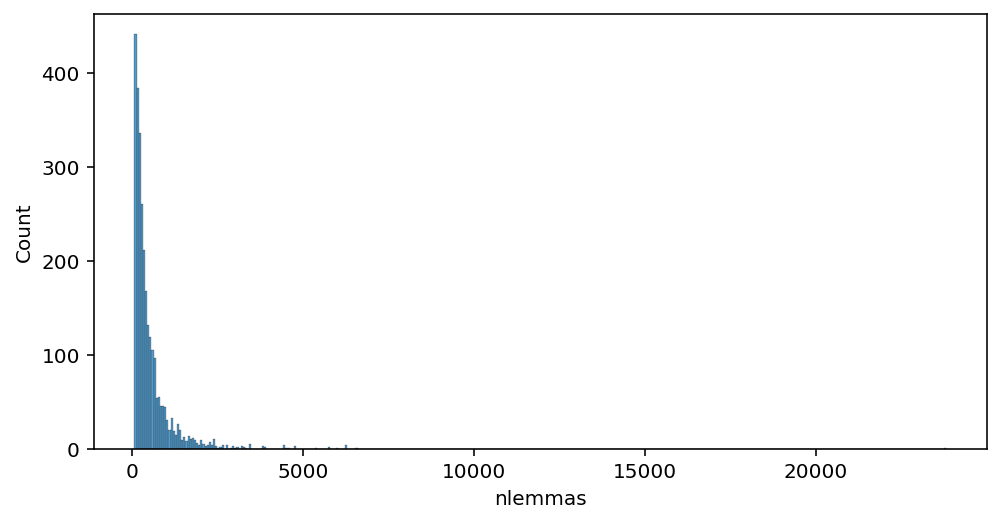

In [15]:
def count_lemmas(x):
    return len(x.split())

NSF_df['nlemmas'] = NSF_df['lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = NSF_df, x='nlemmas')
plt.show()

In [17]:
len(NSF_df[NSF_df['nlemmas']>100])

2676

In the light of these values, we arbitrarily set a threshold on the number of lemmas:
```
min_lemmas = 100
```

In [18]:
NSF_df = NSF_df[NSF_df['nlemmas']>=100]
print('Number of projects in DataFrame after removing short abstracts:', len(NSF_df))

Number of projects in DataFrame after removing short abstracts: 2682


#### 2.2.2 Bag of Words Representation

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.

Note that some text descriptions are duplicated. This is due to the existence of coordinated projects. We will only keep the abstract once when generating the dictionary and the initial topic model.

In [19]:
mycorpus = NSF_df.lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]

import gensim

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 55466 terms
First terms in the dictionary:
0 : access
1 : acid
2 : alfalfa
3 : ammonium
4 : apparent
5 : associate
6 : association
7 : asymptomatic
8 : attribute
9 : bezoar


Next, we will filter out terms that appear in too few or too many of the documents in the dataset. This makes sense because:

   - terms that appear in most documents are probably not very informative in the general context of a particular corpus
   - terms that appear in a very reduced number of documents are not useful to find repetitive patterns across documents. In fact, in many cases we find that many of the words that are eliminated for this reason can be typos.





In [20]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 11673 terms
First terms in the dictionary:
0 : access
1 : acid
2 : apparent
3 : association
4 : asymptomatic
5 : attribute
6 : bowel
7 : calcium
8 : california
9 : carbonate



Next, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such token in `token_list`. 

In [21]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

#### 2.2.3. Create initial topic model

We will create an initial topic model just for the sake of identifying some common words that we believe should be removed.

We train with Mallet

In [22]:
from gensim.models.wrappers import LdaMallet
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=20, id2word=D, alpha=5, iterations=100)

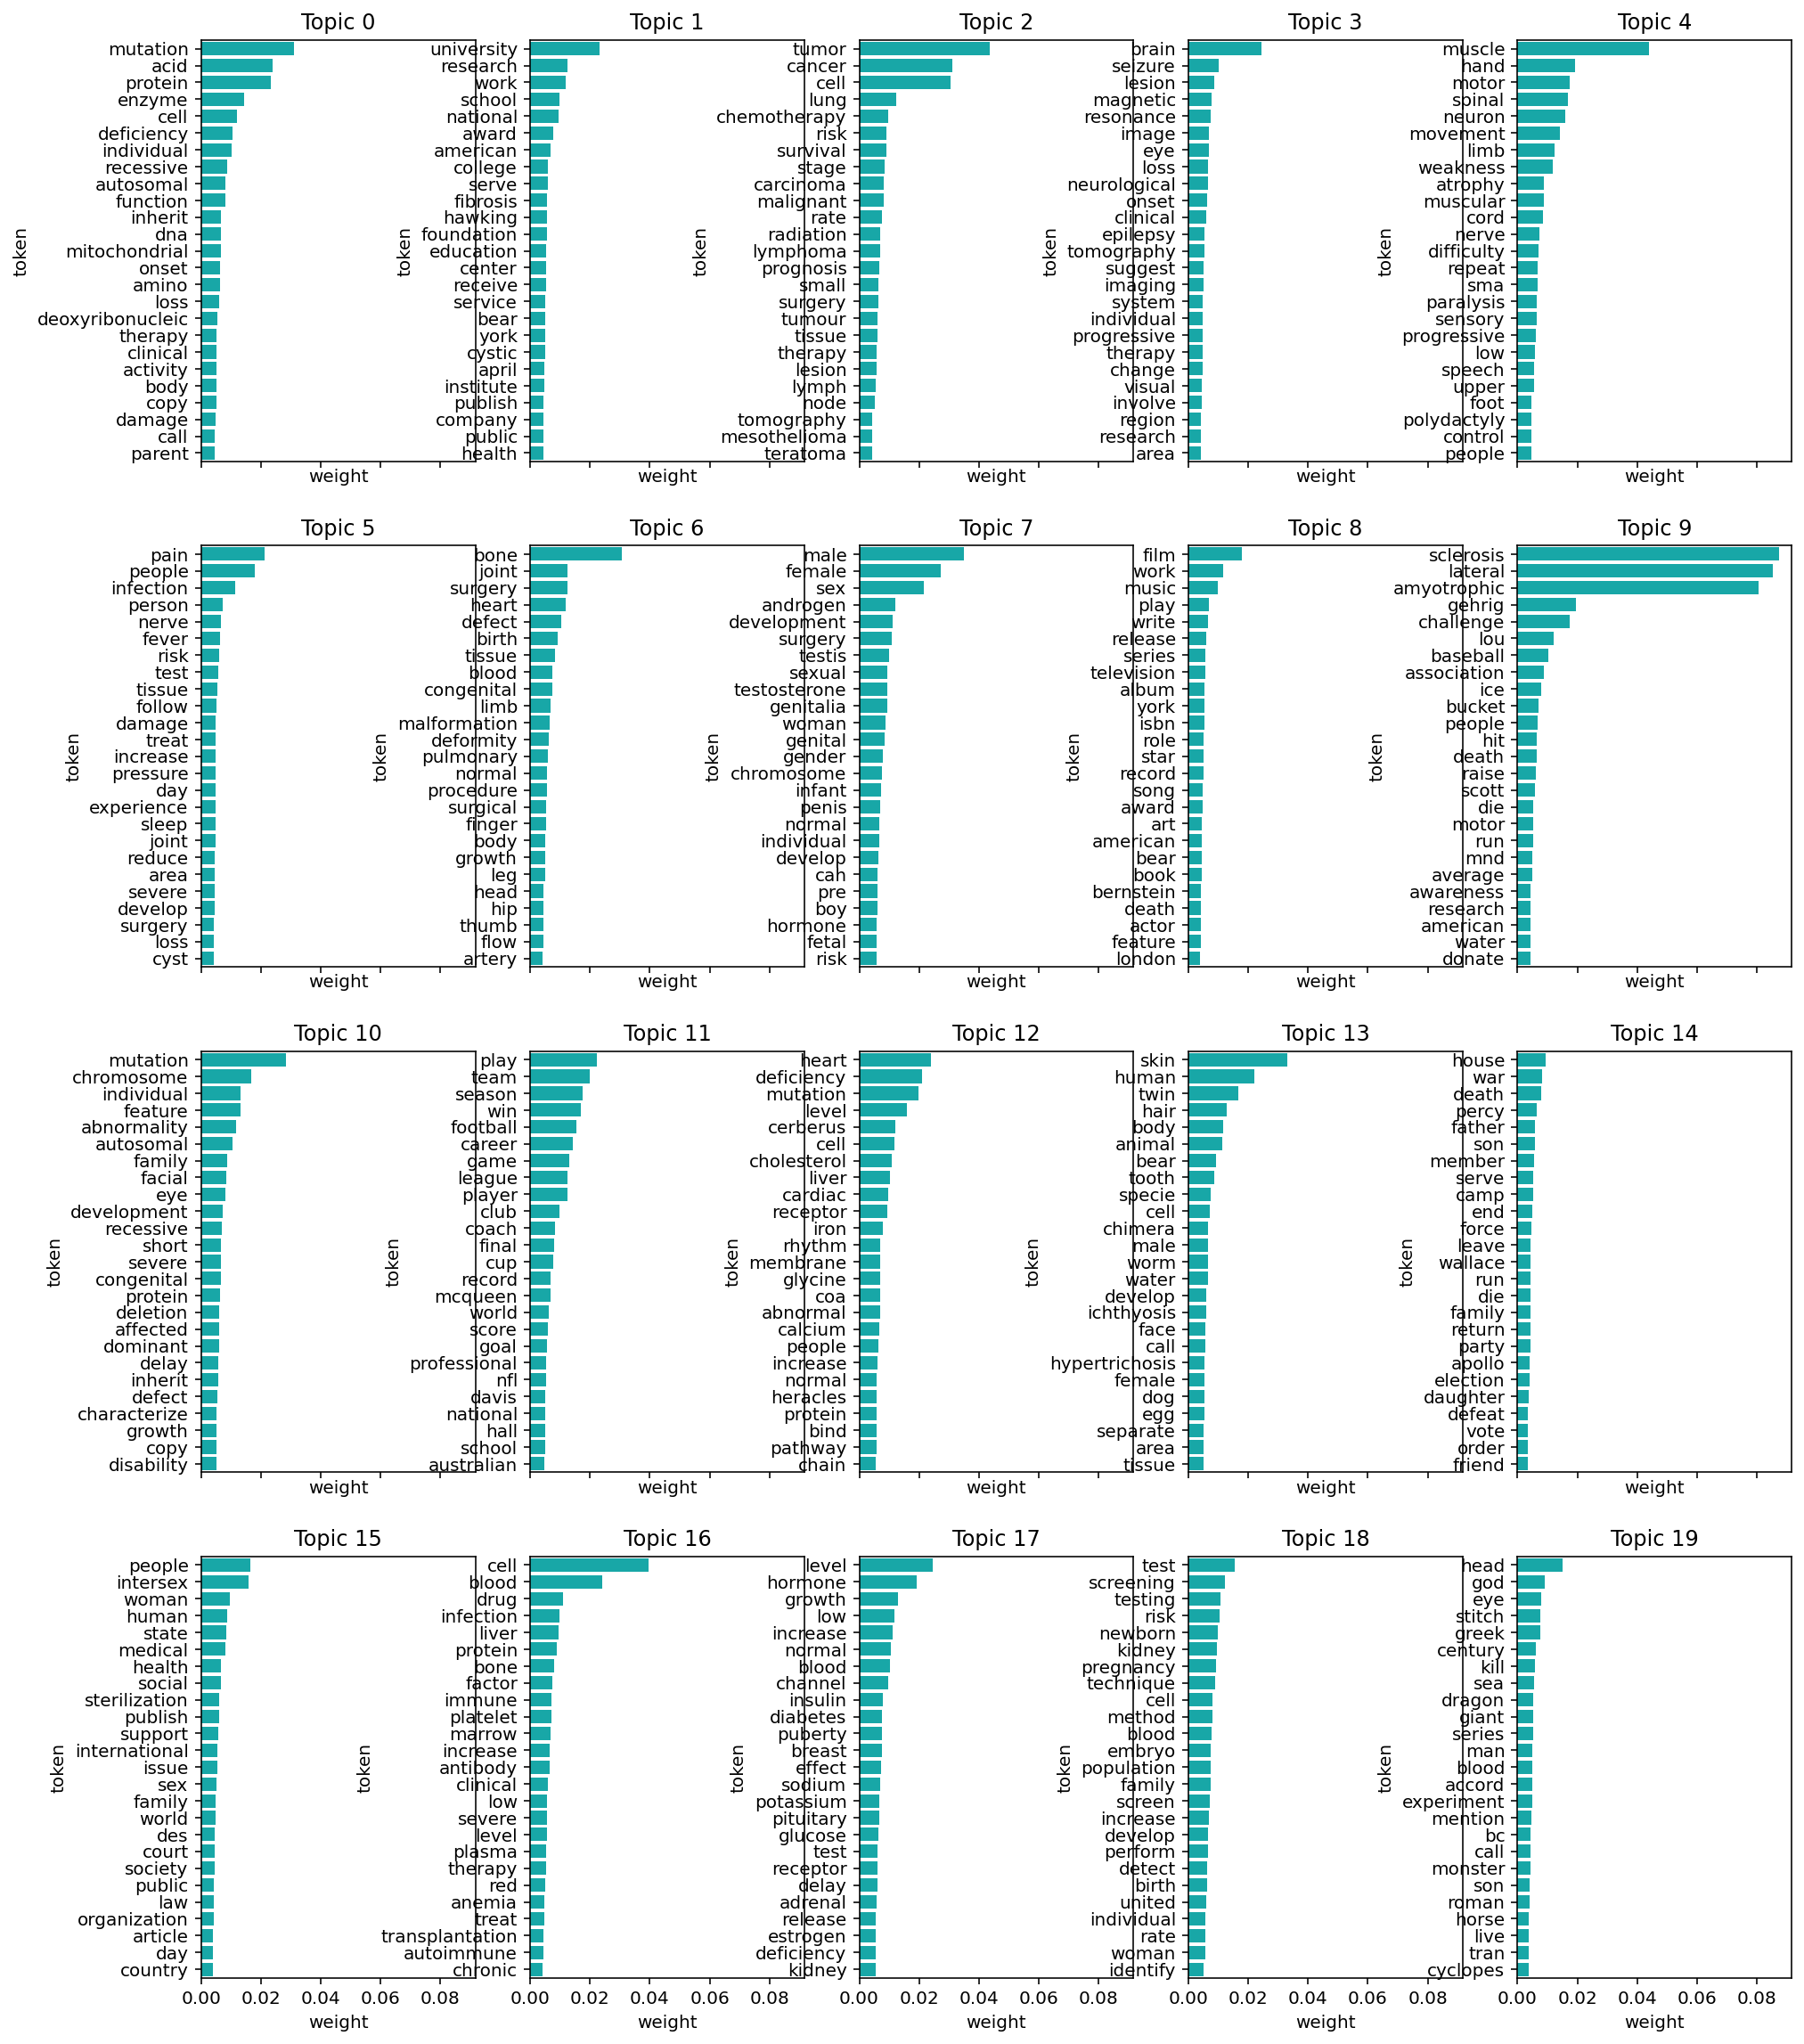

In [24]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

#### 2.2.4. Cleaning the vocabulary

Based on the previous topic descriptions we will add a series of specific stopwords. This process could be repeated several times to get a much better vocabulary, but we will only do it once.

In [ ]:
specific_stw = ['tool',
'user',
'create',
'enable',
'team',
'cost',
'commercial',
'propose',
'reduce',
'improve',
'low',
'enable',
'process',
'increase',
'activity',
'individual',
'people',
'zone',
'large',
'performance',
'examine',
'understand',
'group',
'change',
'understandingfinding',
'affect',
'identify',
'method',
'analysis',
'aim',
'undergraduate',
'specific',
'approach',
'role',
'University',
'Professor',
'conference',
'workshop',
'researcher',
'participant',
'opportunity',
'meeting',
'career',
'graduate',
'hold',
'science',
'international',
'bring',
'participation',
'session',
'topic',
'collaboration',
'present',
'presentation',
'discussion',
'attend',
'management',
'challenge',
'stakeholder',
'address',
'planning',
'scale',
'public',
'fundamental',
'experiment',
'design',
'Research',
'faculty',
'opportunity',
'institution',
'Science',
'Center',
'experience',
'scientific',
'REU',
'site',
'summer',
'education',
'Engineering',
'university',
'mentor',
'STEM',
'teacher',
'education',
'school',
'stem',
'college',
'practice',
'teaching',
'skill',
'knowledge']

#We remove duplicates and capital letters
specific_stw = list(set([el.lower() for el in specific_stw]))

We will apply the changes to the NSF_df dataframe to save them for future use.

In [ ]:
def clean_lemmas(orig_str):
    lemmas = orig_str.lower().split()
    lemmas = [el for el in lemmas if el not in specific_stw]
    return ' '.join(lemmas)

NSF_df['clean_lemmas'] = NSF_df['lemmas'].apply(clean_lemmas)

In [ ]:
#We filter again according to the number of lemmas

NSF_df['nlemmas'] = NSF_df['clean_lemmas'].apply(count_lemmas)
NSF_df = NSF_df[NSF_df['nlemmas']>=100]
print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(NSF_df))

Number of projects in DataFrame after applying specific stopwords and removing short texts: 35691


We end by creating the new vocabulary, and saving both the dataframe and the new vocabulary for persistence

In [ ]:
mycorpus = NSF_df.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 63249 terms
First terms in the dictionary:
0 : algorithm
1 : allocation
2 : answer
3 : apply
4 : aspect
5 : base
6 : behavior
7 : branch
8 : collection
9 : come
The dictionary contains 18931 terms
First terms in the dictionary:
0 : algorithm
1 : allocation
2 : answer
3 : apply
4 : aspect
5 : behavior
6 : branch
7 : collection
8 : come
9 : compare


In [ ]:
NSF_df.to_excel(local_folder + 'NSF_df.xlsx', index=False)
D.save(local_folder + 'clean_gensim.dict')

## **3. Topic Modeling**


### *3.1. Validating the number of topics using coherence*


In [ ]:
NSF_df = pd.read_excel(local_folder + 'NSF_df.xlsx')
D = gensim.corpora.Dictionary.load(local_folder + 'clean_gensim.dict')

In [ ]:
mycorpus = NSF_df.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

Estimating coherence for a model with 5 topics
[0.46970894517150086]
Estimating coherence for a model with 10 topics
[0.46970894517150086, 0.5202253506422003]
Estimating coherence for a model with 15 topics
[0.46970894517150086, 0.5202253506422003, 0.52949108393347]
Estimating coherence for a model with 20 topics
[0.46970894517150086, 0.5202253506422003, 0.52949108393347, 0.5723428440689263]
Estimating coherence for a model with 25 topics
[0.46970894517150086, 0.5202253506422003, 0.52949108393347, 0.5723428440689263, 0.5902685134262831]
Estimating coherence for a model with 35 topics
[0.46970894517150086, 0.5202253506422003, 0.52949108393347, 0.5723428440689263, 0.5902685134262831, 0.6082196926569018]
Estimating coherence for a model with 50 topics
[0.46970894517150086, 0.5202253506422003, 0.52949108393347, 0.5723428440689263, 0.5902685134262831, 0.6082196926569018, 0.597687878723622]
Estimating coherence for a model with 75 topics
[0.46970894517150086, 0.5202253506422003, 0.5294910839

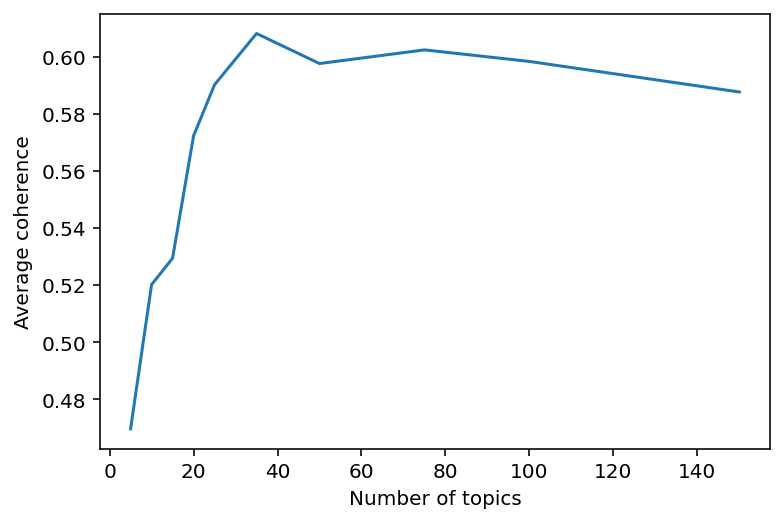

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]
tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)

plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

### *3.2. Document LDA representation*

The previous plot suggests that we should use a model with at least 35 topics. Coherence gets reasonably flat but slightly decreasing from that point on. So we will train our final LDA model with 35 topics.

In [ ]:
import gensim
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

NSF_df = pd.read_excel(local_folder + 'NSF_df.xlsx')
D = gensim.corpora.Dictionary.load(local_folder + 'clean_gensim.dict')

In [ ]:
mycorpus = NSF_df.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=35, id2word=D, alpha=5, iterations=1000)

We visualize the final LDA model

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [ ]:
ldagensim = malletmodel2ldamodel(ldamallet)
vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


The fact that topics are reasonably well scattered in this 2D PCA space implies that the model optimization and the resulting model includes reasonably diverse topics that cover the whole data set.

In order to enrich graph represenation we will label manually the 35 topics that we have obtained.

In [ ]:
tpc_descriptions = []

for ntpc in range(35):
    print(ldagensim.show_topic(ntpc, topn=20))
    desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
    tpc_descriptions.append(desc)

We will add in the NSF_df the following information:
   - LDA representation
   - A column containing the name of the most significant topics

In [ ]:
mycorpus = NSF_df.clean_lemmas.tolist()
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
mycorpus_lda = [ldagensim[el] for el in mycorpus_bow]

In [ ]:
main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in mycorpus_lda]

In [ ]:
NSF_df['LDA_35'] = mycorpus_lda
NSF_df['main_topic_35'] = main_topic

In [ ]:
NSF_df.to_excel(local_folder + 'NSF_df_35topics.xlsx', index=False)

## **4. Analyzing Semantic Similarity Among Documents**

You can check that with 8 B representation (float 64) for each similarity value, the whole similarity matrix of a 35.000 x 35.000 document matrix would require arount 5 GB (exploiting symmetry).

In order to solve this issue note that:
   - Many document pairs will not overlap their topics, consequently their similarity will be zero
   - This implies that a sparse representation will be more efficient in general
   - We can take a look at similarity weights distributions to impose a threshold on the similarity, keeping only the information about pairs of documents with similarity above the threshold

We will start by selecting at random 10.000 documents in order to estimate the weight distribution for the dataset

In [ ]:
NSF_df = pd.read_excel(local_folder + 'NSF_df_35topics.xlsx')

Number of non-zero components in similarity matrix: 74027428
We check the size of the similarity matrix: (10000, 10000)
Ratio of non-zero components: 0.74027428


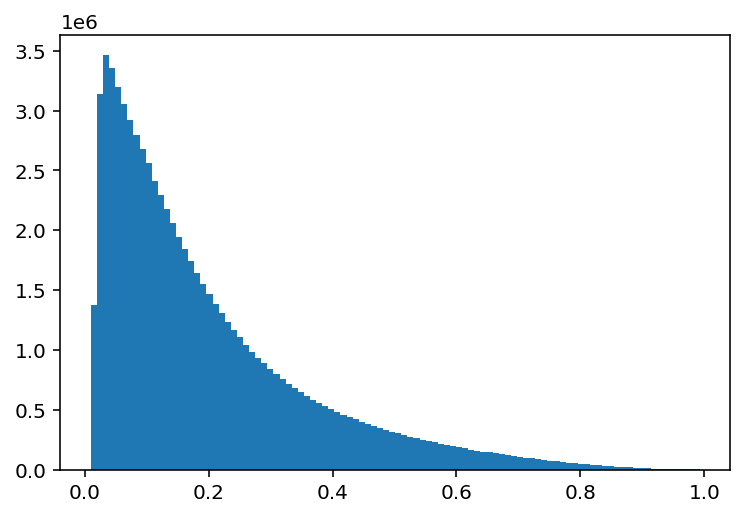

In [ ]:
from gensim.matutils import corpus2csc
from scipy.sparse import triu
from ast import literal_eval

sample_size = 10000
corpus_size = len(NSF_df)
sample_factor = sample_size / corpus_size

X = [literal_eval(el) for el in NSF_df.sample(sample_size)['LDA_35'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
#simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part

print('Number of non-zero components in similarity matrix:', len(simmat.data))
print('We check the size of the similarity matrix:', simmat.shape)
print('Ratio of non-zero components:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])

plt.hist(simmat.data, bins=100)
plt.show()

In [ ]:
thr = 0.4
simmat.data = np.where(simmat.data < thr, 0, simmat.data)
simmat.eliminate_zeros()
len(simmat.data)
print('Estimated number of links in full corpus:', len(simmat.data)/2/sample_factor**2)

Estimated number of links in full corpus: 58550743.46243969


Based on the previous analysis, we see that for the whole dataset the number of links would be barely 58M, and this would require approximately 0.5 GB or RAM space. This is feasible, but computing simmat as an intermediate step still requires the whole 10 GB which will make Colab crash.

Therefore, we will sample the graph from the beginning. Note that, in any case, with Gephi we will not easily be able to explore graphs with more than approximately 1000 nodes.

## **5. Computing CSV files for Gephi**

### *5.1. Nodes CSV file*

In [ ]:
#print(NSF_data[0].keys())
#print(NSF_data[0]['institution'])

sample_size = 2500
print('Creating a graph with', sample_size, 'nodes')
NSF_sample = NSF_df.sample(sample_size)
NSF_sample['Id'] = [el for el in np.arange(sample_size)]
NSF_sample[['Id', 'title', 'year', 'budget', 'institution', 'state', 'main_topic_35']].to_csv(local_folder + 'NSF_nodes.csv', index=False)

Creating a graph with 2500 nodes


### *5.2. Weights CSV file*

In [ ]:
X = [literal_eval(el) for el in NSF_sample['LDA_35'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
simmat.data = np.where(simmat.data < thr, 0, simmat.data)
simmat.eliminate_zeros()
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part
print('Number of links in sampled corpus:', len(simmat.data))
simmat = simmat.tocoo()

Number of links in sampled corpus: 282121


In [ ]:
pd.DataFrame([el for el in zip(simmat.row.tolist(),simmat.col.tolist(),simmat.data.tolist())],
             columns=['Source','Target','Weight']).to_csv(local_folder + 'NSF_edges.csv', index=False)